---
Some useful $\LaTeX$ commands are defined in this cell:
$$
\newcommand{\abs}[1]{\left\lvert#1\right\rvert}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\set}[1]{\left\{#1\right\}}
\newcommand{\paren}[1]{\left(#1\right)}
\newcommand{\brack}[1]{\left[#1\right]}
\newcommand{\ip}[2]{\left\langle#1,#2\right\rangle}
\DeclareMathOperator{\span}{span}
\DeclareMathOperator{\fl}{fl}
\abs{x}, \norm{x}, \set{x}, \paren{x}, \brack{x}, \ip{x}{y}, \span, \fl
$$

---

---
# 15.4 Adaptive quadrature
---

## Example

Let 

$$f(x) = e^{-3x} \sin 4x$$

and suppose we need to calculate $\int_0^4 f(x)\,dx$.

In [1]:
f(x) = exp(-3x).*sin(4x)

f (generic function with 1 method)

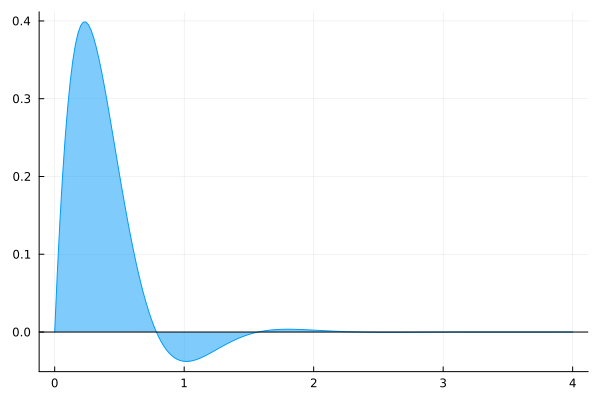

In [2]:
using Plots, LaTeXStrings

a, b = 0, 4

xx = range(a, b, length=200)

plot(axes_style=:zeroline, legend=:none)
plot!(xx, f.(xx), ribbon=(f.(xx), zeros(length(xx))))
hline!([0], c=:black)

Notice how $f(x)$ varies dramatically for $x < 1$ and then has very small variation for $x > 1$.

It would be better to divide the interval $[0,4]$ into many smaller subintervals in the region $[0,1]$ and fewer subintervals in the region $[1,4]$.

We will do this subdivision **adaptively**, only when it helps improve the accuracy of numerical integration.

To do this, we need to obtain a good estimate of the error.

---

## Computing an error estimate via Richardson extrapolation

Let $I_f = \int_a^b f(x) \,dx$ and consider the **Simpson rule** 

$$S(a,b) = \frac{h}{3} \brack{f(a) + 4f(a+h) + f(b)},$$

where $h = (b - a)/2$. 

Let $S_1 = S(a,b)$.

Since the composite Simpson rule is a **fourth-order accurate** method, we have

$$I_f = S_1 + Kh^4 + \mathcal{O}(h^5).$$

Now consider using the **composite Simpson rule** with a step-size of $h/2$ on the subintervals $[a,a+h]$ and $[a+h,b]$:

$$
\begin{align}
S(a,a+h) &= \frac{h}{6}\brack{f(a) + 4f(a + h/2) + f(a + h)},\\
\\
S(a+h,b) &= \frac{h}{6}\brack{f(a+h) + 4f(a + 3h/2) + f(b)}.\\
\end{align}
$$

Let $S_2 = S(a,a+h) + S(a+h,b)$.

Then we have

$$I_f = S_2 + K\paren{\frac{h}{2}}^4 + \mathcal{O}(h^5).$$

Therefore,

$$S_1 + Kh^4 + \mathcal{O}(h^5) = S_2 + K\paren{\frac{h}{2}}^4 + \mathcal{O}(h^5).$$

Then we solve for the error term $Kh^4$:

$$Kh^4 = \frac{16}{15}\brack{S_2 - S_1} + \mathcal{O}(h^5).$$

From this we conclude that

$$ 
\begin{align}
I_f - S_1 &= \frac{16}{15}\brack{S_2 - S_1} + \mathcal{O}(h^5),\\
\\
I_f - S_2 &= \frac{1}{15}\brack{S_2 - S_1} + \mathcal{O}(h^5).\\
\end{align}
$$

---

## Example

Consider

$$I_f = \int_{-1}^1 \cos\paren{\frac{\pi}{2} x} \,dx = \frac{4}{\pi} = \underline{1.2732395447351628} \ldots .$$

The **Simpson rule** gives us:

$$S_1 = \frac{2}{6}\paren{0 + 4 \cdot 1 + 0} = \frac{4}{3} =  \underline{1.3}333333333333333 \ldots .$$

Thus, the error is 

$$\abs{I_f - S_1} = 0.060093788598170494\ldots.$$

In [3]:
f(x) = cos(pi/2*x)

f (generic function with 1 method)

In [4]:
If = 4/pi
S1 = (f(-1) + 4f(0) + f(1))/3

@show If
@show S1
@show abs(If - S1);

If = 1.2732395447351628
S1 = 1.3333333333333333
abs(If - S1) = 0.060093788598170494


Now let's compute $S_2$:

$$
\begin{align}
S_2 
&= \frac{1}{6}\paren{f(-1) + 4f(-.5) + 2f(0) + 4f(.5) + f(1)} \\
&= \frac{1}{6}\paren{0 + \frac{4}{\sqrt{2}} + 2 + \frac{4}{\sqrt{2}} + 0} \\
&= \underline{1.27}61423749153966\ldots.\\
\end{align}
$$

The error is

$$\abs{I_f - S_2} = 0.0029028301802338508\ldots.$$

In [5]:
S2 = (f(-1) + 4f(-.5) + 2f(0) + 4f(.5) + f(1))/6

@show If
@show S2
@show abs(If - S2);

If = 1.2732395447351628
S2 = 1.2761423749153966
abs(If - S2) = 0.0029028301802338508


Now, let's compare our error estimates. We have

$$
\begin{align}
\abs{I_f - S_1} &\approx \frac{16}{15}\abs{S_2 - S_1} = \underline{0.06}100368897913242\ldots,\\
\\
\abs{I_f - S_2} &\approx \frac{1}{15}\abs{S_2 - S_1} = \underline{0.003}8127305611957763\ldots.\\
\end{align}
$$

Thus, the error estimates are fairly accurate.

In [6]:
@show 16/15*abs(S2 - S1)
@show 1/15*abs(S2 - S1);

(16 / 15) * abs(S2 - S1) = 0.06100368897913242
(1 / 15) * abs(S2 - S1) = 0.0038127305611957763


---

## Divide-and-conquer

We now describe a **divide-and-conquer** approach to obtain a quadrature approximation $Q_f$ of $I_f = \int_a^b f(x)\,dx$ such that

$$\abs{Q_f - I_f} < \mathtt{tol},$$

where $\mathtt{tol}$ is some user-specified tolerance.

The idea is to do an **adaptive local refinement** of the grid of points on which we perform the composite Simpson rule (or any other quadrature rule):

$$a = t_0 < t_1 < \cdots < t_r = b.$$

Over each subinterval $[t_{i-1}, t_i]$, we compute $Q_i \approx I_i = \int_{t_{i-1}}^{t_i} f(x)\,dx$ such that

$$\abs{Q_i - I_i} < \frac{h_i}{b-a}\mathtt{tol},$$

where $h_i = t_i - t_{i-1}$, and then let

$$Q_f = \sum_{i=1}^r Q_i.$$

Then,

$$\begin{split}
\abs{Q_f - I_f}
&= \abs{\sum_{i=1}^r Q_i - \sum_{i=1}^r I_i} \\
&= \abs{\sum_{i=1}^r (Q_i - I_i)} \\
&\leq \sum_{i=1}^r \abs{ Q_i - I_i} \qquad \text{(by the Triangle Inequality)}\\
&< \sum_{i=1}^r \frac{h_i}{b - a} \mathtt{tol} \\
&= \frac{\mathtt{tol}}{b - a}  \sum_{i=1}^r h_i \\
&= \mathtt{tol}.
\end{split}
$$

Thus, we just need to check that our error estimate for the current subinterval is small enough.

If the error estimate is not small enough, we divide the current subinterval into two equal pieces and repeat (recursively).

---

## A simple recursive implementation

In [7]:
############################################################
function Simp1(f::Function, a::Float64, b::Float64)
    h = (b - a)/2
    return h/3*(f(a) + 4f(a + h) + f(b))
end

############################################################
Simp2(f, a::Float64, b::Float64) = Simp1(f, a, (a+b)/2) + Simp1(f, (a+b)/2, b)

############################################################
function quadsimp(f::Function, a::Float64, b::Float64, tol::Float64)
    
    h = (b - a)/2
    
    S1 = Simp1(f, a, b)
    S2 = Simp2(f, a, b)
    
    E2 = abs(S2 - S1)/15
    
    if E2 < tol
        Q = S2
        mesh = [a, a+h/2, a+h, a+3h/2, b]
    else
        Q1, mesh1 = quadsimp(f, a, (a+b)/2, tol/2)
        Q2, mesh2 = quadsimp(f, (a+b)/2, b, tol/2)
        Q = Q1 + Q2
        mesh = vcat(mesh1, mesh2[2:end])
    end
    
    return Q, mesh
end

quadsimp (generic function with 1 method)

In [8]:
f(x) = exp(-3x).*sin(4x)

f (generic function with 1 method)

In [9]:
using SymPy

x = SymPy.symbols("x")

intval = Float64(integrate(f(x), (x, a, b)))

0.16000115372280727

In [10]:
integrate(f(x), (x, a, b))

     -12              -12             
  3⋅ℯ   ⋅sin(16)   4⋅ℯ   ⋅cos(16)   4 
- ────────────── - ────────────── + ──
        25               25         25

In [11]:
a, b, tol = 0., 4., 1e-4
Q, mesh = quadsimp(f, a, b, tol)

@show abs(intval - Q);

abs(intval - Q) = 2.9624451541754304e-5


In [12]:
length(mesh)

29

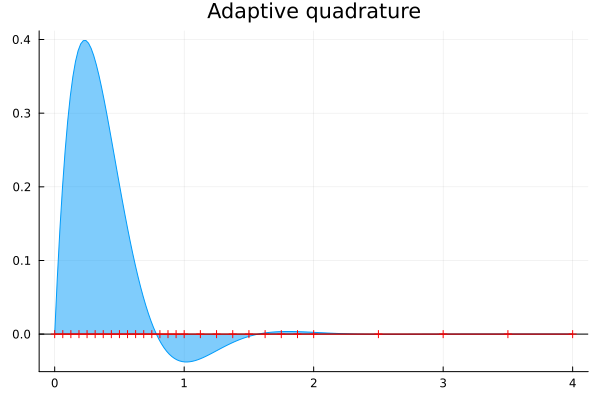

In [13]:
xx = range(a, b, length=200)

plot(legend=:none, title="Adaptive quadrature")
plot!(xx, f.(xx), ribbon=(f.(xx), zeros(length(xx))))
hline!([0], c=:black)
plot!(mesh, zeros(length(mesh)), m=:+, c=:red)

In [14]:
using Printf

tols = [10.0^(-k) for k=1:16]

quads = Float64[]
fevals = Int64[]
tt = Float64[]
for tol in tols
    t = @elapsed Q, mesh = quadsimp(f, a, b, tol)
    push!(quads, Q)
    push!(fevals, length(mesh))
    push!(tt, t)
end
    
abserr = abs.(quads .- intval)

@printf "%6s %10s %7s %10s\n" "tol" "abserr" "fevals" "time"
for k = 1:length(tols)
    @printf "%6.0e %10.2e %7d %10.6f\n" tols[k] abserr[k] fevals[k] tt[k]
end

   tol     abserr  fevals       time
 1e-01   2.09e-01       5   0.000009
 1e-02   2.09e-01       5   0.000007
 1e-03   3.45e-05      17   0.000004
 1e-04   2.96e-05      29   0.000005
 1e-05   5.26e-06      49   0.000008
 1e-06   5.55e-08      97   0.000017
 1e-07   4.83e-10     177   0.000029
 1e-08   4.92e-10     321   0.000052
 1e-09   6.89e-11     521   0.000084
 1e-10   4.70e-12     881   0.000139
 1e-11   4.78e-13    1621   0.000253
 1e-12   3.94e-14    3017   0.000472
 1e-13   5.97e-15    5605   0.000877
 1e-14   5.55e-16   10005   0.001626
 1e-15   5.55e-17   16173   0.002575
 1e-16   0.00e+00   27917   0.004474


---

## Example

The number of prime numbers less or equal to $x$ is denoted $\pi(x)$.

The [prime number theorem](https://en.wikipedia.org/wiki/Prime_number_theorem#Prime-counting_function_in_terms_of_the_logarithmic_integral) states that

$$
\pi(x) \sim \int_2^x \frac{dt}{\log t}.
$$

In [15]:
using Primes

x = 200

primes(x)

46-element Vector{Int64}:
   2
   3
   5
   7
  11
  13
  17
  19
  23
  29
  31
  37
  41
   ⋮
 149
 151
 157
 163
 167
 173
 179
 181
 191
 193
 197
 199

In [16]:
f(t) = 1/log(t)
a, b, tol = 2., Float64(x), 1e-6

Q, mesh = quadsimp(f, a, b, tol)

length(primes(x)), Q, length(mesh)

(46, 49.14700770037625, 329)

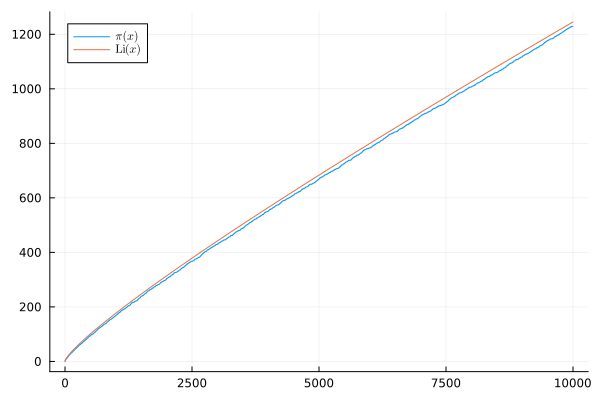

In [17]:
n = 10000

px = [length(primes(k)) for k=2:n];
Li = [quadsimp(f, 2., Float64(k), tol)[1] for k=2:n];

plot(legend=:topleft)
plot!(px, label=L"\pi(x)")
plot!(Li, label=L"\mathrm{Li}(x)")
#plot!(Li./px, label=L"\mathrm{Li}(x)/\pi(x)")

---

In [18]:
using QuadGK

In [19]:
?quadgk

search: quadgk quadgk! quads QuadGK quadsimp quadgk_count quadgk_print



```
quadgk(f, a,b,c...; rtol=sqrt(eps), atol=0, maxevals=10^7, order=7, norm=norm, segbuf=nothing, eval_segbuf=nothing)
```

Numerically integrate the function `f(x)` from `a` to `b`, and optionally over additional intervals `b` to `c` and so on. Keyword options include a relative error tolerance `rtol` (if `atol==0`, defaults to `sqrt(eps)` in the precision of the endpoints), an absolute error tolerance `atol` (defaults to 0), a maximum number of function evaluations `maxevals` (defaults to `10^7`), and the `order` of the integration rule (defaults to 7). Returns a pair `(I,E)` of the estimated integral `I` and an estimated upper bound on the absolute error `E`. If `maxevals` is not exceeded then `E <= max(atol, rtol*norm(I))` will hold. (Note that it is useful to specify a positive `atol` in cases where `norm(I)` may be zero.)

The endpoints `a` et cetera can also be complex (in which case the integral is performed over straight-line segments in the complex plane). If the endpoints are `BigFloat`, then the integration will be performed in `BigFloat` precision as well.

!!! note
    It is advisable to increase the integration `order` in rough proportion to the precision, for smooth integrands.


More generally, the precision is set by the precision of the integration endpoints (promoted to floating-point types).

Instead of passing the integration domain as separate arguments `a,b,c...`, you can alternatively pass the domain as a single argument: an array of endpoints `[a,b,c...]` or an array of interval tuples `[(a,b), (b,c)]`. (The latter enables you to integrate over a disjoint domain if you want.)

The integrand `f(x)` can return any numeric scalar, vector, or matrix type, or in fact any type supporting `+`, `-`, multiplication by real values, and a `norm` (i.e., any normed vector space). Alternatively, a different norm can be specified by passing a `norm`-like function as the `norm` keyword argument (which defaults to `norm`).

!!! note
    Only one-dimensional integrals are provided by this function. For multi-dimensional integration (cubature), there are many different algorithms (often much better than simple nested 1d integrals) and the optimal choice tends to be very problem-dependent. See the Julia external-package listing for available algorithms for multidimensional integration or other specialized tasks (such as integrals of highly oscillatory or singular functions).


The algorithm is an adaptive Gauss-Kronrod integration technique: the integral in each interval is estimated using a Kronrod rule (`2*order+1` points) and the error is estimated using an embedded Gauss rule (`order` points). The interval with the largest error is then subdivided into two intervals and the process is repeated until the desired error tolerance is achieved.

These quadrature rules work best for smooth functions within each interval, so if your function has a known discontinuity or other singularity, it is best to subdivide your interval to put the singularity at an endpoint. For example, if `f` has a discontinuity at `x=0.7` and you want to integrate from 0 to 1, you should use `quadgk(f, 0,0.7,1)` to subdivide the interval at the point of discontinuity. The integrand is never evaluated exactly at the endpoints of the intervals, so it is possible to integrate functions that diverge at the endpoints as long as the singularity is integrable (for example, a `log(x)` or `1/sqrt(x)` singularity).

For real-valued endpoints, the starting and/or ending points may be infinite. (A coordinate transformation is performed internally to map the infinite interval to a finite one.)

In normal usage, `quadgk(...)` will allocate a buffer for segments. You can instead pass a preallocated buffer allocated using `alloc_segbuf(...)` as the `segbuf` argument.  Alternatively, one can replace the first `quadgk(...)` call with `quadgk_segbuf(...)` to return the segment buffer from a given call.  This buffer can be used across multiple calls to avoid repeated allocation.   Upon return from `quadgk`, the `segbuf` array contains an array of subintervals that were used for the final quadrature evaluation.

By passing `eval_segbuf=segbuf` to a subsequent call to `quadgk`, these subintervals can be re-used as the starting point for the next integrand evaluation (over the same domain), even for an integrand of a different result type; by also passing `maxevals=0`, further refinement of these subintervals is prohibited, so that it forces the same quadrature rule to be used (which is useful for evaluating e.g. derivatives of the approximate integral).

---

```
quadgk(f::BatchIntegrand, a,b,c...; kws...)
```

Like [`quadgk`](@ref), but batches evaluation points for an in-place integrand to evaluate simultaneously. In particular, there are two differences from `quadgk`

1. The function `f.f!` should be of the form `f!(y, x) = y .= f.(x)`.  That is, it writes the return values of the integand `f(x)` in-place into its first argument `y`. (The return value of `f!` is ignored.) See [`BatchIntegrand`](@ref) for how to define the integrand.
2. `f.max_batch` changes how the adaptive refinement is done by batching multiple segments together. Choosing `max_batch<=4*order+2` will reproduce the result of non-batched `quadgk`, however if `max_batch=n*(4*order+2)` up to `2n` Kronrod rules will be evaluated together, which can produce slightly different results and sometimes require more integrand evaluations when using relative tolerances.


---